
[Ссылка на датасет](https://www.kaggle.com/datasets/keenwarrior/small-flicker-data-for-image-captioning)

[Ссылка на статью](https://openai.com/research/clip)


In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
PATH_TO_IMAGES = "/kaggle/input/small-flicker-data-for-image-captioning/flickr1k"

In [3]:
to_tensor = T.ToTensor()
import typing as tp

class CLIPDataset(Dataset):
    def __init__(self, image_path, image_filenames, captions, tokenizer):
        """
        :image_path -- path to images
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        :tokenizer -- LM Tokenizer 
        """
        self.max_tokenizer_length = 200
        self.truncation = True
        self.padding = True
        self.image_path = image_path
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.tokenizer = tokenizer
        self.encoded_captions = self.tokenizer(self.captions, truncation=self.truncation, 
                                               padding=self.padding, max_length=self.max_tokenizer_length)
        self.transforms = T.Compose([T.Resize([224, 244]), to_tensor]) # This should do.

    def __getitem__(self, idx: int) -> tp.Dict[str, tp.Union[torch.Tensor, str]]:

        """
        This one should return dict(keys=['image', 'caption'], value=[Image, Caption])
        """
        item = {
            key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()
        }
        item['image'] = Image.open(f'{self.image_path}/{self.image_filenames[idx]}').convert('RGB')
        item['image'] = self.transforms(item['image'])
        item['caption'] = self.captions[idx]
        return item


    def __len__(self):
        return len(self.captions)

In [19]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector.
    """
    def __init__(
        self, model_name="resnet50", pretrained=True, trainable=False
        ):
        """
        We will use standard pretrained ResNet50, and set freeze its parameters.
        Look the documentation of TIMM on how to donwload the model: https://timm.fast.ai/
        """
        super().__init__()
        self.model = timm.create_model(model_name, num_classes=0, pretrained=pretrained)
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [34]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()

        """
        Here you should write simple 2-layer MLP consisting:
        2 Linear layers, GELU activation, Dropout and LayerNorm. 
        Do not forget to send a skip-connection right after projection and before LayerNorm.
        The whole structure should be in the following order:
        [Linear, GELU, Linear, Dropout, Skip, LayerNorm]
        """
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc1 = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        """
        Perform forward pass, do not forget about skip-connections.
        """
        proj = self.projection(x)
        out = self.dropout(self.fc1(self.gelu(proj)))
        return self.norm(proj + out)

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=False):
        super().__init__()
        """
        Create the model and set its weights frozen. 
        Use Transformers library docs to find out how to do this.
        """
        # use the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0
        
        self.model = (
            DistilBertModel.from_pretrained(pretrained_model_name_or_path=model_name) 
            if pretrained else 
            DistilBertModel(DistilBertConfig())
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, input_ids, attention_mask):
        """
        Pass the arguments through the model and make sure to return CLS token embedding
        """
        return self.model(input_ids, attention_mask).last_hidden_state[:, self.target_token_idx]

In [39]:
class CLIP(nn.Module):
    def __init__(self, image_embedding=2048, text_embedding=768, projection_dim=256, temp=1.0, dropout=0.1):
        super().__init__()
        self.image_encoder = ImageEncoder(pretrained=True, trainable=False)
        self.text_encoder = TextEncoder(pretrained=True, trainable=False)
        self.image_projections = ProjectionHead(image_embedding, projection_dim, dropout)
        self.text_projections = ProjectionHead(text_embedding, projection_dim, dropout)
        self.temp = nn.Parameter(torch.tensor(temp))

    def forward(self, batch):
        """
        :batch: dict of images and text
        Here is what you should do:
        1) extract image and text features from batch
        2) project features into projection space (small latent space)
        3) compute cosine similarity with temperature this will be your logits
        4) compute "true" logits (eg. cosine similarity between images and images, text and text)
        5) create targets by averaging similarities from step above (do not forget about temperature)
        6) compute mean loss (see paper)
        7) return loss

        Overall: read paper.
        
        """
        emb_img = self.image_projections(self.image_encoder(batch['image']))
        emb_txt = self.text_projections(self.text_encoder(batch['input_ids'], batch['attention_mask']))

        emb_img = emb_img / torch.sqrt((emb_img**2).sum(axis=1))[:, None]
        emb_txt = emb_txt / torch.sqrt((emb_txt**2).sum(axis=1))[:, None]

        logits = torch.exp(self.temp) * (emb_img @ emb_txt.T)
        softmax = nn.Softmax(dim=-1)
        true_logits = softmax(torch.exp(self.temp) / 2 * (emb_img @ emb_img.T + emb_txt @ emb_txt.T))

        loss1 = CE(logits, true_logits)
        loss2 = CE(logits.T, true_logits.T)

        return (loss1.mean() + loss2.mean()) / 2
    

def CE(preds, targets):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    return loss   

In [13]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{PATH_TO_IMAGES}/captions.csv")
    dataframe["id"] = np.array(list(dataframe.index))
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [14]:
def build_loaders(dataframe, tokenizer, mode):
    dataset = CLIPDataset(
        f"{PATH_TO_IMAGES}/images",
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer
    )
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        num_workers=1,
        shuffle=True if mode == "train" else False,
    )
    return dataloader, dataset

In [15]:
class AvgMeter:
    def __init__(self, name="CrossEntropyLoss"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text
    
    def __format__(self, formatspec):
        text = f"{self.name}: {format(self.avg, formatspec)}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

@torch.no_grad()
def validate(model, validation_loader):
    loss_meter = AvgMeter()
    for batch in tqdm(validation_loader, desc="Validating", total=len(validation_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

In [17]:
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 10
def procedure():
    train_df, validation_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_loader, _ = build_loaders(train_df, tokenizer, mode="train")
    val_loader, _ = build_loaders(validation_df, tokenizer, mode="valid")
    model = CLIP().to(device)
    params = [{"params": model.image_encoder.parameters()}, 
              {"params" : model.text_encoder.parameters()},
              {"params" : itertools.chain(model.image_projections.parameters(),
                                          model.text_projections.parameters())}]
    optimizer = torch.optim.Adam(params)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=1, factor=0.8)
    step="epoch"
    for epoch in range(EPOCH):
        print(f"Epoch: {epoch}. Train and Validation in progress...")
        model.train()
        train_loss = train(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        val_loss = validate(model, val_loader)
        
        lr_scheduler.step(val_loss.avg)
        print(f"Epoch: {epoch},", end="\n")
        print(f"Train loss: {train_loss:0.3f}", end="\n")
        print(f"Validation loss: {val_loss:0.3f}")
    return model

In [40]:
model = procedure()

Epoch: 0. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0,
Train loss: CrossEntropyLoss: 3.466
Validation loss: CrossEntropyLoss: 3.455
Epoch: 1. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1,
Train loss: CrossEntropyLoss: 3.465
Validation loss: CrossEntropyLoss: 3.455
Epoch: 2. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2,
Train loss: CrossEntropyLoss: 3.436
Validation loss: CrossEntropyLoss: 3.179
Epoch: 3. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3,
Train loss: CrossEntropyLoss: 3.113
Validation loss: CrossEntropyLoss: 3.074
Epoch: 4. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4,
Train loss: CrossEntropyLoss: 3.030
Validation loss: CrossEntropyLoss: 2.946
Epoch: 5. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5,
Train loss: CrossEntropyLoss: 2.938
Validation loss: CrossEntropyLoss: 2.944
Epoch: 6. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6,
Train loss: CrossEntropyLoss: 2.902
Validation loss: CrossEntropyLoss: 2.841
Epoch: 7. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7,
Train loss: CrossEntropyLoss: 2.870
Validation loss: CrossEntropyLoss: 2.828
Epoch: 8. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8,
Train loss: CrossEntropyLoss: 2.859
Validation loss: CrossEntropyLoss: 2.819
Epoch: 9. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9,
Train loss: CrossEntropyLoss: 2.840
Validation loss: CrossEntropyLoss: 2.814


In [46]:
@torch.inference_mode()
def get_image_embeddings(valid_df, model):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    valid_loader, _ = build_loaders(valid_df, tokenizer, mode="valid")
    valid_image_embeddings = []
    for batch in tqdm(valid_loader, desc="Getting embeddings", total=len(valid_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        image_features = model.image_encoder(batch["image"].permute(0, 1, 2, 3)).to(device)
        image_embeddings = model.image_projections(image_features)
        valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

In [47]:
import matplotlib.pyplot as plt
@torch.inference_mode()
def find_match(model, image_embeddings, text, image_filenames, num_examples=4):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    text_encoded = tokenizer([text])
    batch = {key : torch.tensor(value).to(device) for key, value in text_encoded.items()}
    
    text_features = model.text_encoder(batch["input_ids"], batch["attention_mask"])
    text_embeddings = model.text_projections(text_features)
    
    norm_image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=-1)
    norm_text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=-1)
    
    similarity = norm_text_embeddings @ norm_image_embeddings.T
    
    ans, ans_index = torch.topk(similarity.squeeze(0), num_examples * 5)
    match = [image_filenames[index] for index in ans_index[::5]]
    fig, ax = plt.subplots(int(num_examples/2), int(num_examples/2), figsize= (10, 10))
    for m, a in zip(match, ax.flatten()):
        image = Image.open(f"{PATH_TO_IMAGES}/images" + f"/{m}")
        image = image.convert("RGB")
        a.imshow(image)
        a.axis("off")
    plt.show()
    

In [48]:
_, valid_df = make_train_valid_dfs()
image_embeddings = get_image_embeddings(valid_df, model)

Getting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

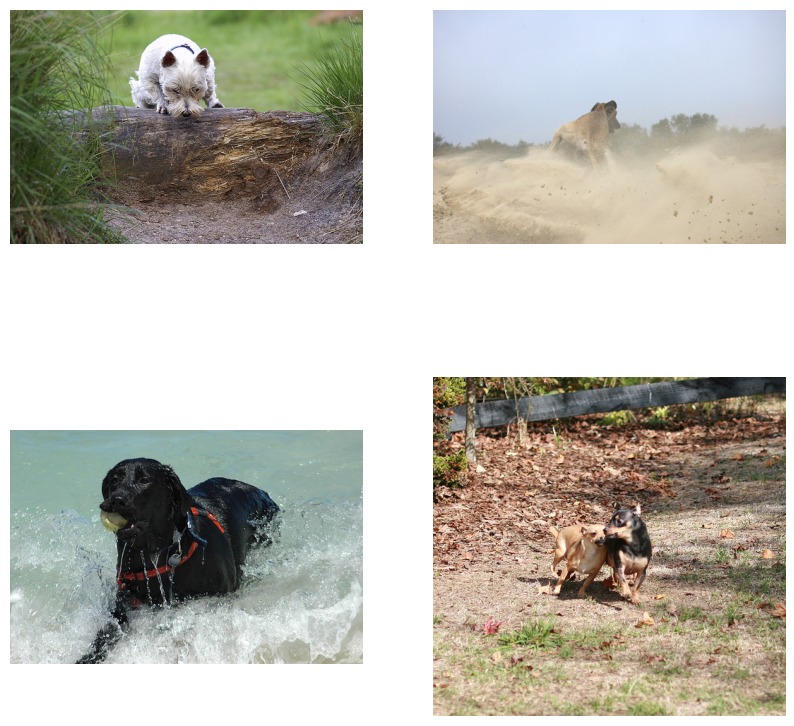

In [49]:
find_match(model, image_embeddings, "dogs", valid_df["image"].values)

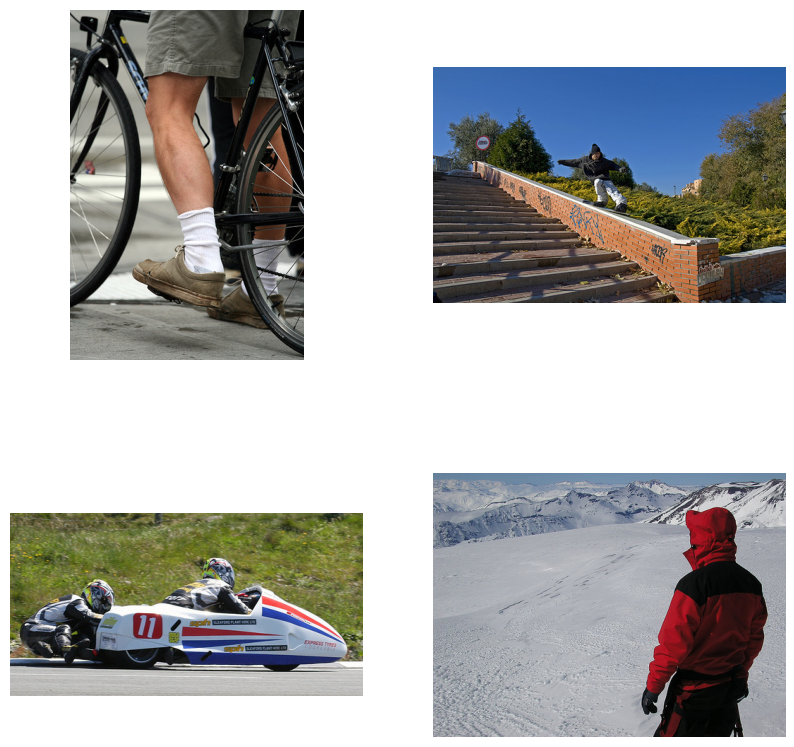

In [50]:
find_match(model, image_embeddings, "man", valid_df["image"].values)

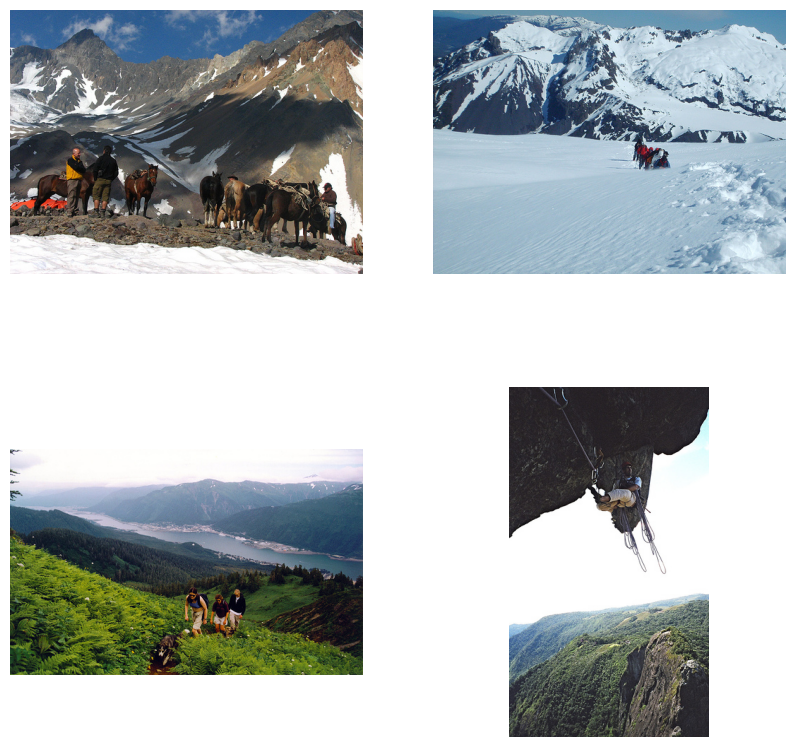

In [51]:
find_match(model, image_embeddings, "mountain", valid_df["image"].values)

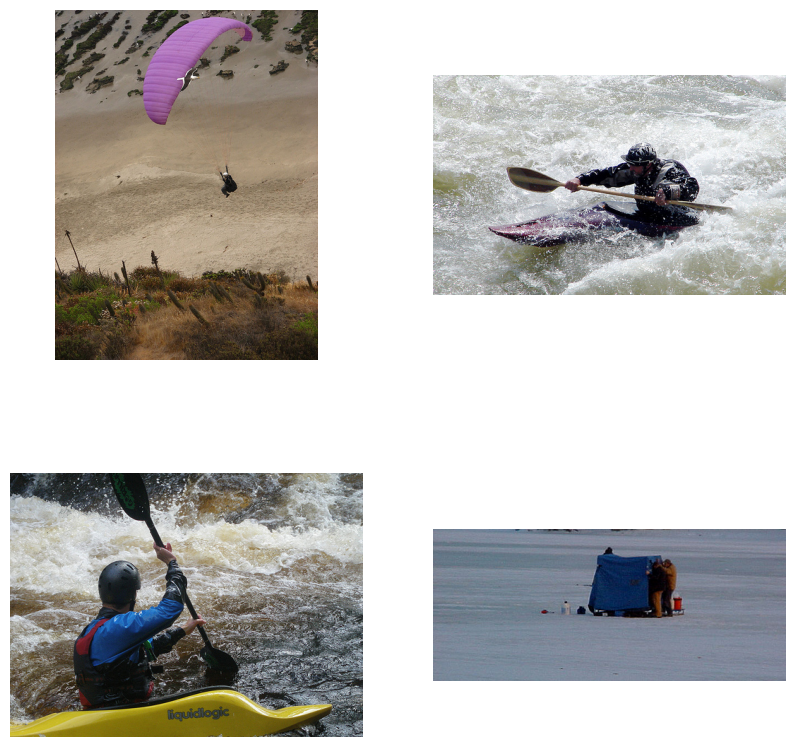

In [52]:
find_match(model, image_embeddings, "sea", valid_df["image"].values)

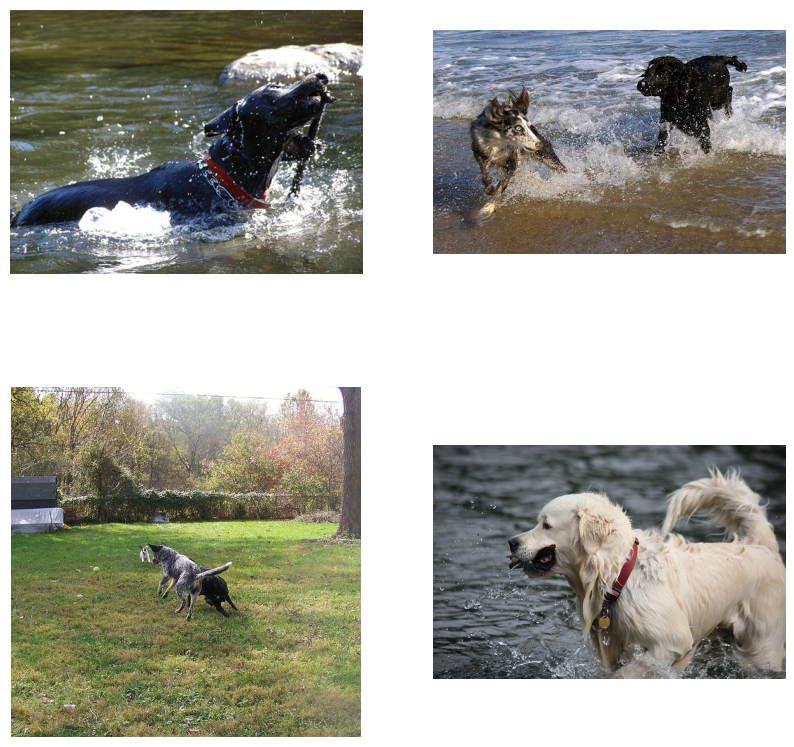

In [60]:
find_match(model, image_embeddings, "birds", valid_df["image"].values)

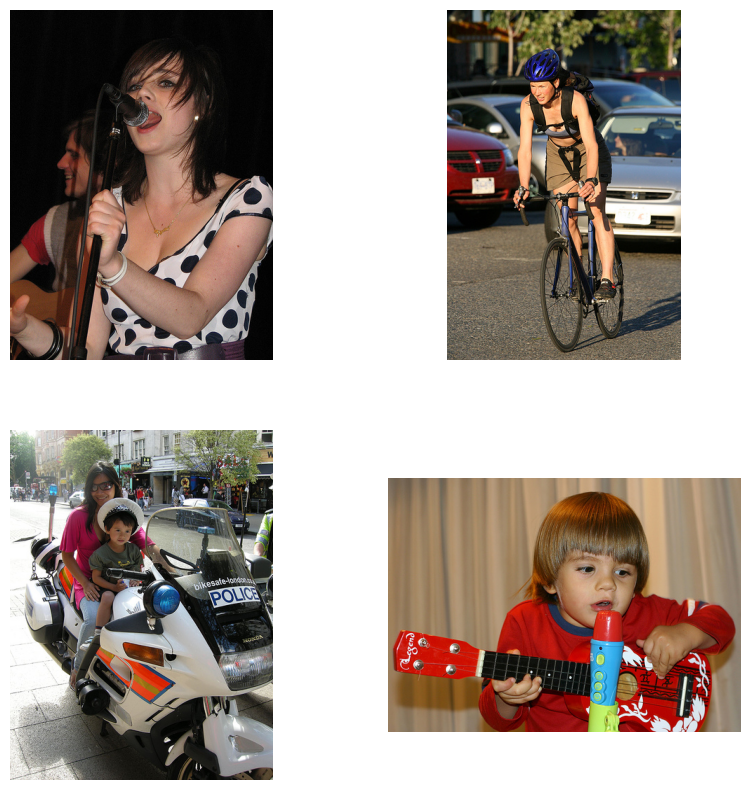

In [61]:
find_match(model, image_embeddings, "womans", valid_df["image"].values)

Работает очень даже неплохо, однако если картинок с каким-то промтом было мало, то модель будет выдавать что-то смежное по смыслу - например на животных она выдаёт собак